In [31]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from rdkit import Chem
from rdkit.Chem import Draw, MolToSmiles, PandasTools
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map

from metlin_filtering import BASE_DIR, SEED
from metlin_filtering.preprocessing import load_processed_data
from IPython.display import display

In [32]:
BASE_DIR, SEED

(WindowsPath('D:/Research/metlin-filtering'), 44)

In [33]:
MODEL_NAMES = [
    "CNN",
    "FCD",
    "FCFP",
    "GNN",
    "CB"
]

In [34]:
OUTPUT_FOLDER = BASE_DIR / "data" / "output"

In [35]:
def generate_statistics(dataframe):
    cols = ["GNN", "CNN", "FCFP", "FCD", "CB"]
    dataframe["p_median"] = dataframe.loc[:, cols].median(axis=1)
    dataframe["p_mean"] = dataframe.loc[:, cols].mean(axis=1)
    dataframe["p_std"] = dataframe.loc[:, cols].std(axis=1)
    dataframe["d_median"] = (dataframe.loc[:, "EXP"] -
                             dataframe.loc[:, "p_median"]).abs()
    dataframe["d_median_R"] = (dataframe["d_median"] /
                               dataframe.loc[:, "p_median"]).abs()

    dataframe[f"S_5"] = np.zeros(len(dataframe))
    dataframe[f"S_5_R"] = np.zeros(len(dataframe))
    dataframe[f"S_5_B"] = np.zeros(len(dataframe))
    for col in cols:
        dataframe[f"d_{col}"] = (dataframe.loc[:, col] -
                                 dataframe.loc[:, "EXP"]).abs()
        dataframe[f"d_{col}_R"] = dataframe.loc[:, f"d_{col}"] / dataframe.loc[:, "p_median"].abs()
        
        abs_mask = dataframe[f"d_{col}"] >= dataframe[f"d_{col}"].quantile(float(
            (100 - 5) / 100))
        rel_mask = dataframe[f"d_{col}_R"] >= dataframe[f"d_{col}_R"].quantile(float((100 - 5) / 100))

        dataframe.loc[abs_mask, f"S_5"] += 1
        dataframe.loc[rel_mask, f"S_5_R"] += 1
        dataframe.loc[abs_mask&rel_mask, f"S_5_B"] += 1

## Combine predictions into a database

In [36]:
# all_predictions = {}
# for name in MODEL_NAMES:
#     predictions = []
#     for file in OUTPUT_FOLDER.glob(f'*-{name}_*s.npy'):
#         predictions.append(np.load(file).ravel()*1000)
#     all_predictions[name] = np.concatenate(predictions,axis=0)

In [37]:
# predicted_df = pd.DataFrame(all_predictions)
# predicted_df

In [38]:
# input_inchi, input_molecules, input_retention_times = load_processed_data(
#         BASE_DIR / "data" / "processed" / "clean_inchi_400_plus.csv")

# print("Preparing SMILES")
# input_smiles = np.array(thread_map(
#     MolToSmiles, input_molecules, chunksize=500))

# unique_smiles, unique_index, unique_inverse = np.unique(
#     input_smiles, return_index=True, return_inverse=True
# )


In [39]:
# kf = KFold(5, shuffle=True, random_state=SEED)
# inp_retention_times = []
# inp_smiles = []
# for k, (unique_train_idx, unique_eval_idx) in enumerate(kf.split(
#         np.arange(len(unique_smiles)))):

#     input_train_idx = unique_index[unique_train_idx]
#     input_eval_idx = unique_index[unique_eval_idx]

#     eval_retention_times = input_retention_times[input_eval_idx]
#     eval_smiles = input_smiles[input_eval_idx]

#     inp_retention_times.append(eval_retention_times*1000)
#     inp_smiles.append(eval_smiles)
# inp_retention_times = np.concatenate(inp_retention_times)
# inp_smiles = np.concatenate(inp_smiles)

In [40]:
# predicted_df["EXP"] = inp_retention_times
# predicted_df["SMILES"] = inp_smiles

In [41]:
# predicted_df.to_csv(BASE_DIR / "data" / "output"/ f"predicted-rts-{SEED}.csv")

## Dataframes with SEED=42, re-runs

In [42]:
brun_dataframes = []
for file in OUTPUT_FOLDER.glob("predicted-rts-?.csv"):
    brun_dataframes.append((file.stem.split("-")[-1],pd.read_csv(file, index_col=0)))

In [43]:
for df in brun_dataframes:
    generate_statistics(df[1])

In [44]:
prediction_stats = []
for df in brun_dataframes:
    prediction_stats.append(df[1].loc[:,[f"d_{x}" for x in MODEL_NAMES]].agg(["mean","median"]))
    display(f"SEED {df[0]}",prediction_stats[-1])
pd.concat(prediction_stats, axis=1).reset_index().melt(id_vars="index").groupby(["index","variable"]).agg(["mean", "std"])

'SEED 0'

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
mean,38.001342,40.181548,36.126192,30.460909,39.745439
median,20.900000,23.300000,20.000000,15.300000,22.400000


'SEED 1'

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
mean,38.271303,40.366496,36.058584,30.489732,39.745443
median,21.235250,23.572925,19.950880,15.247975,22.406258


'SEED 2'

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
mean,38.120007,40.256819,36.073441,30.410407,39.745443
median,21.163650,23.467550,20.134150,15.300900,22.406258


value          
                      mean       std
index  variable                     
mean   d_CB      39.745441  0.000002
       d_CNN     38.130884  0.135309
       d_FCD     40.268288  0.093006
       d_FCFP    36.086072  0.035530
       d_GNN     30.453683  0.040153
median d_CB      22.404172  0.003613
       d_CNN     21.099633  0.176555
       d_FCD     23.446825  0.137638
       d_FCFP    20.028343  0.094866
       d_GNN     15.282958  0.030300

In [45]:
group_5_size = [len(x[1][x[1]["S_5_B"]==5]) for x in brun_dataframes]
group_5_size,np.mean(group_5_size),np.std(group_5_size)

([1544, 1560, 1545], 1549.6666666666667, 7.318166133366716)

Intersection between re-runs

In [46]:
full_intersection = brun_dataframes[0][1]["SMILES"].to_numpy()
for df in brun_dataframes:
    full_intersection = np.intersect1d(full_intersection,df[1][df[1]["S_5_B"]==5]["SMILES"].to_numpy())
len(full_intersection)

1361

## Dataframes with different SEED for KFold splits

In [47]:
dataframes = []
for file in OUTPUT_FOLDER.glob("predicted-rts-??.csv"):
    dataframes.append((file.stem.split("-")[-1],pd.read_csv(file, index_col=0)))

In [48]:
for df in dataframes:
    generate_statistics(df[1])

### MAE and MdAE

Plain, full METLIN

In [49]:
prediction_stats = []
for df in dataframes:
    prediction_stats.append(df[1].loc[:,[f"d_{x}" for x in MODEL_NAMES]].agg(["mean","median"]))
    display(f"SEED {df[0]}",prediction_stats[-1])
pd.concat(prediction_stats, axis=1).reset_index().melt(id_vars="index").groupby(["index","variable"]).agg(["mean", "std"])

'SEED 42'

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
mean,38.120007,40.256819,36.073441,30.410407,39.745443
median,21.163650,23.467550,20.134150,15.300900,22.406258


'SEED 43'

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
mean,38.382514,40.455653,36.177394,30.556022,39.669716
median,21.339650,23.695120,20.107700,15.364550,22.194978


'SEED 44'

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
mean,38.37409,40.236584,36.148907,30.516528,39.745223
median,21.42920,23.363670,20.062800,15.247475,22.287045


value          
                      mean       std
index  variable                     
mean   d_CB      39.720127  0.043658
       d_CNN     38.292203  0.149186
       d_FCD     40.316352  0.121062
       d_FCFP    36.133247  0.053717
       d_GNN     30.494319  0.075306
median d_CB      22.296094  0.105930
       d_CNN     21.310833  0.135100
       d_FCD     23.508780  0.169528
       d_FCFP    20.101550  0.036070
       d_GNN     15.304308  0.058612

Without potentially erroneous retention times

In [50]:
prediction_stats = []
for df in dataframes:
    prediction_stats.append(df[1].loc[df[1]["S_5_B"]<5,[f"d_{x}" for x in MODEL_NAMES]].agg(["mean","median"]))
    display(f"SEED {df[0]}",prediction_stats[-1])
pd.concat(prediction_stats, axis=1).reset_index().melt(id_vars="index").groupby(["index","variable"]).agg(["mean", "std"])

'SEED 42'

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
mean,32.875072,35.111949,30.83353,25.052049,34.714834
median,20.570400,22.868330,19.57280,14.899870,21.797919


'SEED 43'

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
mean,33.099934,35.250203,30.903822,25.130971,34.588076
median,20.729400,23.061500,19.557500,14.955200,21.625965


'SEED 44'

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
mean,33.227661,35.124008,30.937213,25.176661,34.738436
median,20.872700,22.738150,19.515175,14.846300,21.705405


value          
                      mean       std
index  variable                     
mean   d_CB      34.680448  0.080863
       d_CNN     33.067556  0.178511
       d_FCD     35.162054  0.076577
       d_FCFP    30.891521  0.052925
       d_GNN     25.119894  0.063040
median d_CB      21.709763  0.086060
       d_CNN     20.724167  0.151218
       d_FCD     22.889327  0.162694
       d_FCFP    19.548492  0.029850
       d_GNN     14.900457  0.054452

### Correlations

Plain, full METLIN

In [51]:
for df in dataframes:
    display(f"SEED {df[0]}",len(df[1].loc[:,[f"d_{x}" for x in MODEL_NAMES]]),df[1].loc[:,[f"d_{x}" for x in MODEL_NAMES]].corr())

'SEED 42'

77878

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
d_CNN,1.000000,0.729045,0.786577,0.787170,0.777520
d_FCD,0.729045,1.000000,0.754814,0.739380,0.768843
d_FCFP,0.786577,0.754814,1.000000,0.817404,0.812022
d_GNN,0.787170,0.739380,0.817404,1.000000,0.762897
d_CB,0.777520,0.768843,0.812022,0.762897,1.000000


'SEED 43'

77878

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
d_CNN,1.000000,0.713705,0.785393,0.781323,0.776131
d_FCD,0.713705,1.000000,0.738879,0.725896,0.754636
d_FCFP,0.785393,0.738879,1.000000,0.817507,0.815409
d_GNN,0.781323,0.725896,0.817507,1.000000,0.760484
d_CB,0.776131,0.754636,0.815409,0.760484,1.000000


'SEED 44'

77878

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
d_CNN,1.000000,0.701106,0.784621,0.783265,0.773489
d_FCD,0.701106,1.000000,0.725907,0.712454,0.740642
d_FCFP,0.784621,0.725907,1.000000,0.814790,0.812458
d_GNN,0.783265,0.712454,0.814790,1.000000,0.758482
d_CB,0.773489,0.740642,0.812458,0.758482,1.000000


For adequately predicted retention times

In [52]:
corr_stats = []
for df in dataframes:
    masked_df = df[1].loc[df[1]["d_median"].abs() < 100,[f"d_{x}" for x in MODEL_NAMES]]
    corr_stats.append(masked_df.corr())
    display(f"SEED {df[0]}",len(masked_df)/len(df[1]),masked_df.corr())

'SEED 42'

0.9435655769280156

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
d_CNN,1.000000,0.294129,0.371315,0.387355,0.375879
d_FCD,0.294129,1.000000,0.328712,0.316256,0.395163
d_FCFP,0.371315,0.328712,1.000000,0.424602,0.450652
d_GNN,0.387355,0.316256,0.424602,1.000000,0.351369
d_CB,0.375879,0.395163,0.450652,0.351369,1.000000


'SEED 43'

0.944130563188577

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
d_CNN,1.000000,0.274245,0.363058,0.380317,0.371968
d_FCD,0.274245,1.000000,0.307300,0.297035,0.375476
d_FCFP,0.363058,0.307300,1.000000,0.422958,0.456096
d_GNN,0.380317,0.297035,0.422958,1.000000,0.342061
d_CB,0.371968,0.375476,0.456096,0.342061,1.000000


'SEED 44'

0.9439122730424511

,d_CNN,d_FCD,d_FCFP,d_GNN,d_CB
d_CNN,1.000000,0.267764,0.361873,0.381674,0.364733
d_FCD,0.267764,1.000000,0.301857,0.290746,0.370177
d_FCFP,0.361873,0.301857,1.000000,0.421079,0.452154
d_GNN,0.381674,0.290746,0.421079,1.000000,0.336213
d_CB,0.364733,0.370177,0.452154,0.336213,1.000000


In [53]:
corr_stats_df = pd.concat(corr_stats, axis=1).reset_index().melt("index").groupby(
    ["index", "variable"]).agg(["mean", "std"]).round(3).unstack()["value"]
corr_stats_df.columns = corr_stats_df.columns.swaplevel(0, 1)
corr_stats_df.sort_index(level=0, axis=1, inplace=True)
corr_stats_df

variable   d_CB         d_CNN         d_FCD        d_FCFP         d_GNN       
           mean    std   mean    std   mean    std   mean    std   mean    std
index                                                                         
d_CB      1.000  0.000  0.371  0.006  0.380  0.013  0.453  0.003  0.343  0.008
d_CNN     0.371  0.006  1.000  0.000  0.279  0.014  0.365  0.005  0.383  0.004
d_FCD     0.380  0.013  0.279  0.014  1.000  0.000  0.313  0.014  0.301  0.013
d_FCFP    0.453  0.003  0.365  0.005  0.313  0.014  1.000  0.000  0.423  0.002
d_GNN     0.343  0.008  0.383  0.004  0.301  0.013  0.423  0.002  1.000  0.000

### Statistics for potentially erroneous retention times

In [54]:
group_5_size = [len(x[1][x[1]["S_5_B"]==5]) for x in dataframes]
group_5_size,np.mean(group_5_size),np.std(group_5_size)

([1545, 1543, 1514], 1534.0, 14.165686240583852)

In [55]:
for df in dataframes:
    display(f"SEED {df[0]}",df[1][(df[1]["S_5_B"] == 5)].describe()["d_median"])

'SEED 42'

count    1545.000000
mean      294.042295
std       116.849329
min       137.236940
25%       207.446740
50%       266.191700
75%       347.444979
max       827.019000
Name: d_median, dtype: float64

'SEED 43'

count    1543.000000
mean      296.834656
std       117.164107
min       136.507750
25%       210.178832
50%       267.936400
75%       346.235037
max       806.701000
Name: d_median, dtype: float64

'SEED 44'

count    1514.000000
mean      297.003161
std       117.410049
min       136.059250
25%       212.031303
50%       270.386845
75%       342.781125
max       799.614500
Name: d_median, dtype: float64

Percentages

In [56]:
for df in dataframes:
    display(f"SEED {df[0]}",len(df[1][(df[1]["S_5_B"] == 5)])/len(df[1])*100)

'SEED 42'

1.9838722103803386

'SEED 43'

1.9813040910141504

'SEED 44'

1.9440663602044224

Intersection between all 3 sets of potentially erroneous entries with different SEEDs

In [57]:
full_intersection = dataframes[0][1]["SMILES"].to_numpy()
for df in dataframes:
    full_intersection = np.intersect1d(full_intersection,df[1][df[1]["S_5_B"]==5]["SMILES"].to_numpy())
len(full_intersection)

1299

In [58]:
np.savetxt(OUTPUT_FOLDER/"potentially_erroneous_list.txt",full_intersection, "%s")

In [59]:
data = {}
for df in dataframes:
    # sns.barplot(x=np.arange(1, 6), y=df[1].groupby("S_5_B").size().to_numpy()[1:], ax=ax )
    data[df[0]] = df[1].groupby("S_5_B").size().to_numpy()[1:]
data = pd.DataFrame(data)
data["# yellow cards"] = np.arange(1,6)
data

,42,43,44,# yellow cards
0,3064,3017,2977,1
1,1130,1154,1186,2
2,645,649,633,3
3,521,511,531,4
4,1545,1543,1514,5


### Plots for the group sizes

<Axes: xlabel='# yellow cards', ylabel='# entries'>

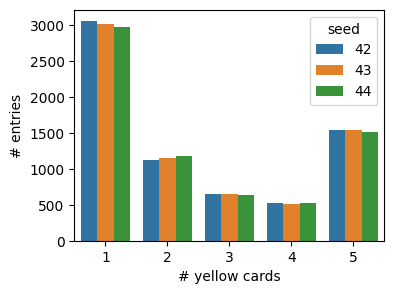

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(data.melt(id_vars="# yellow cards", var_name="seed", value_name="# entries"),
            x="# yellow cards", y="# entries", hue="seed", ax = ax)

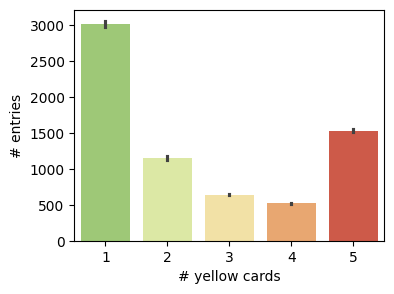

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(data.melt(id_vars="# yellow cards", var_name="seed", value_name="# entries"),
            x="# yellow cards", y="# entries", hue="# yellow cards", errorbar="sd", ax = ax, palette=sns.color_palette("RdYlGn_r",n_colors=6)[1:])
ax.legend().remove()
# ax.grid(axis="y")
fig.savefig(OUTPUT_FOLDER/"fig-num.png",dpi=1000)

### Estimation of the number of incorrectly predicted retention times by Group Sizes

In [62]:
def fit_func(x,a,b,c):
    return a+b/(x+c)

approximations = []
for df in dataframes:
    group_nums=df[1].groupby("S_5_B", as_index=False)["SMILES"].count()["SMILES"].to_list()
    res,_ = curve_fit(fit_func,
            np.arange(0,5),
            np.log2(group_nums[:-1]),
            p0=(1,10,1))
    print(res)
    approximations.append(np.exp2(fit_func(np.arange(6),*res)))
approximations = np.vstack(approximations)[:,1:]

[7.29662437 8.31214393 0.94248908]
[7.2900222  8.32988319 0.94393996]
[7.363405   8.07037966 0.92214574]


Difference between approximated and observed

In [63]:
diff_data = data.drop("# yellow cards",axis=1).T - approximations
diff_data

,0,1,2,3,4
42,11.565984,16.031596,-32.921128,16.609528,1130.453807
43,-34.015669,41.550663,-27.569203,7.834366,1129.589881
44,-46.566246,69.162040,-52.517177,17.930308,1090.519751


In [64]:
diff_data.mean(axis=0),diff_data.std(axis=0)

(0     -23.005310
 1      42.248100
 2     -37.669169
 3      14.124734
 4    1116.854480
 dtype: float64,
 0    30.590195
 1    26.572088
 2    13.134240
 3     5.487501
 4    22.810634
 dtype: float64)

In [65]:
diff_5 = diff_data[4] - data.drop(columns="# yellow cards").mean(axis=1)[4]
diff_5.mean(), diff_5.std()

(-417.1455201665983, 22.8106342658196)

In [66]:
approximations.mean(axis=0), approximations.std(axis=0)

(array([3042.33864325, 1114.41856698,  680.00250241,  506.87526611,
         417.14552017]),
 array([13.28671303,  1.81970462,  3.93832867,  4.40857063,  4.50327698]))

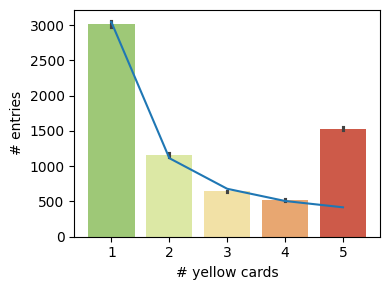

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=100)
sns.barplot(data.melt(id_vars="# yellow cards", var_name="seed", value_name="# entries"),
            x="# yellow cards", y="# entries", hue="# yellow cards", errorbar="sd", ax = ax, palette=sns.color_palette("RdYlGn_r",n_colors=6)[1:])
ax.errorbar(np.arange(0,5),approximations.mean(axis=0),yerr=approximations.std(axis=0))
ax.legend().remove()
fig.tight_layout()
fig.savefig(OUTPUT_FOLDER/"fig-num-est.png",dpi=1000)

### Generating Histograms

In [68]:
bins = np.linspace(0,400,200)
xlim = 30
hist0s = []
hist1s = []
hist5s = []
coeffs = []
for df in dataframes:
    hist0 = np.histogram(df[1][df[1]["S_5_B"] == 0]["p_std"],bins=bins)
    hist0s.append(hist0[0]/len(df[1][df[1]["S_5_B"]==0]))
    hist5 = np.histogram(df[1][df[1]["S_5_B"] == 5]["p_std"],bins=bins)
    hist5s.append(hist5[0]/len(df[1][df[1]["S_5_B"]==5]))
    hist1 = np.histogram(df[1][df[1]["S_5_B"] == 1]["p_std"],bins=bins)
    hist1s.append(hist1[0]/len(df[1][df[1]["S_5_B"]==1]))
    hist0_sum = np.sum(hist0[0][bins[:-1]<xlim-0.5]/len(df[1][df[1]["S_5_B"]==0]))
    hist5_sum = np.sum(hist5[0][bins[:-1]<xlim-0.5]/len(df[1][df[1]["S_5_B"]==5]))
    coeff = hist0_sum/hist5_sum
    coeffs.append(coeff)
hist0s = np.vstack(hist0s)
hist1s = np.vstack(hist1s)
hist5s = np.vstack(hist5s)

In [69]:
hist0s.sum(axis=1),hist1s.sum(axis=1),hist5s.sum(axis=1)

(array([1., 1., 1.]),
 array([0.99934726, 0.99933709, 0.99865637]),
 array([1., 1., 1.]))

In [70]:
hist_diff = hist5s*np.array(coeffs).reshape(3,1)-hist0s
hist_diff = np.sum(np.clip(hist_diff,0,None),axis=1)/np.array(coeffs)
display(hist_diff)
hist_diff = hist_diff*data.drop(columns="# yellow cards").T[4]
hist_diff

array([0.18870247, 0.20364904, 0.20003672])

42    291.545317
43    314.230467
44    302.855596
Name: 4, dtype: float64

In [71]:
hist_diff.mean(),data.drop(columns="# yellow cards").T[4].mean() - hist_diff.mean(), hist_diff.std()

(302.8771265536386, 1231.1228734463614, 11.342590236457958)

Check the difference between 0 groups

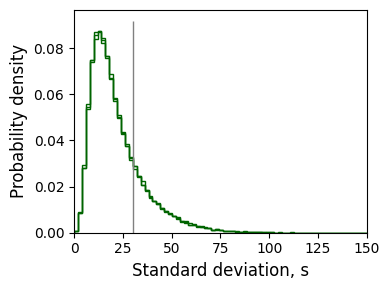

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=100)
histtype = "step"
colors = ["darkgreen",
          "yellowgreen",
          "wheat",
          "grey",
          "firebrick",
          "red"]
for hist in hist0s:
    ax.stairs(hist, bins,
          label=f'{0} "yellow cards"', lw=1,  color=colors[0])

ax.vlines(xlim,0,ax.get_ylim()[1], color="gray", lw=1)
ax.set_ylabel('Probability density', fontsize=12)
ax.set_xlabel('Standard deviation, s', fontsize=12)
ax.set_xbound(0, 150)
# fig.suptitle('Probability density for STD in 1 and 5 marks groups')
# plt.legend(fontsize=12)
# fig.suptitle()
fig.tight_layout()

Check the difference between 5 groups

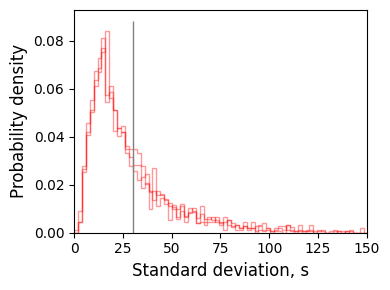

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=100)
histtype = "step"
colors = ["darkgreen",
          "yellowgreen",
          "wheat",
          "grey",
          "firebrick",
          "red"]
for hist in hist5s:
    ax.stairs(hist, bins,
          label=f'5 "yellow cards"', lw=1,  color=colors[5], alpha=0.4)

ax.vlines(xlim,0,ax.get_ylim()[1], color="gray", lw=1)
ax.set_ylabel('Probability density', fontsize=12)
ax.set_xlabel('Standard deviation, s', fontsize=12)
ax.set_xbound(0, 150)
# fig.suptitle('Probability density for STD in 1 and 5 marks groups')
# plt.legend(fontsize=12)
# fig.suptitle()
fig.tight_layout()

Plot combined histograms

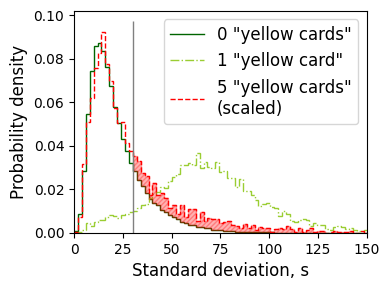

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=100)
histtype = "step"
colors = ["darkgreen",
          "yellowgreen",
          "wheat",
          "grey",
          "firebrick",
          "red"]
ax.stairs(hist0s.mean(axis=0), bins,
          label=f'{0} "yellow cards"', lw=1,  color=colors[0])
ax.stairs(hist1s.mean(axis=0), bins,
          label=f'{1} "yellow card"', lw=1,  color=colors[1], ls="dashdot")
# ax.stairs(hist5s.mean(axis=0), bins,
#           label=f'{5} "yellow cards"', lw=1,  color=colors[5], alpha=0.3)
ax.stairs(hist5s.mean(axis=0)*np.mean(coeffs), bins,
          label=f'{5} "yellow cards"\n(scaled)', lw=1,  color=colors[5], ls="dashed")

mask = ((hist5s.mean(axis=0)*np.mean(coeffs)-hist0s.mean(axis=0)) > 0)&(bins[1:]>xlim)
ax.fill_between(
    bins[1:],
    y1=hist5s.mean(axis=0)*np.mean(coeffs),
    y2=hist0s.mean(axis=0), interpolate=False, step="pre",
    where=mask,
    hatch="///////",
    color="red",
    alpha=0.3
)
ax.vlines(xlim,0,ax.get_ylim()[1], color="gray", lw=1)
ax.set_ylabel('Probability density', fontsize=12)
ax.set_xlabel('Standard deviation, s', fontsize=12)
ax.set_xbound(0, 150)
# fig.suptitle('Probability density for STD in 1 and 5 marks groups')
plt.legend(fontsize=12)
# fig.suptitle()
fig.tight_layout()
fig.savefig(OUTPUT_FOLDER/"fig-distr-est.png",dpi=1000)

### Examples

In [51]:
intersection_df = dataframes[0][1][[True if x in full_intersection else False for x in dataframes[0][1]["SMILES"]]].copy()
intersection_df

,CNN,FCD,FCFP,GNN,CB,EXP,SMILES,p_median,p_mean,p_std,...,d_GNN,d_GNN_R,d_CNN,d_CNN_R,d_FCFP,d_FCFP_R,d_FCD,d_FCD_R,d_CB,d_CB_R
270,807.00140,817.08360,799.23810,779.51056,768.167195,960.9,CC(C)(C)C(=O)Oc1ccc(S(=O)(=O)Nc2ccccc2C(O)=NCC...,799.238100,794.200171,20.039985,...,181.38944,0.226953,153.89860,0.192557,161.66190,0.202270,143.81640,0.179942,192.732805,0.241146
322,1356.92590,1404.40010,1372.46280,1338.74210,1351.615954,1011.6,CC(C)(C)c1csc(-c2csc(S(=O)(=O)NC3CCCCCC3)c2)n1,1356.925900,1364.829371,25.207721,...,327.14210,0.241091,345.32590,0.254491,360.86280,0.265941,392.80010,0.289478,340.015954,0.250578
336,829.21216,897.73180,851.76820,845.07900,884.713579,670.8,CC(C)(C)n1nnnc1[C@H]1CC2(CCOCC2)C(=O)N1Cc1ccc(...,851.768200,861.700948,28.540644,...,174.27900,0.204608,158.41216,0.185980,180.96820,0.212462,226.93180,0.266424,213.913579,0.251141
424,696.90894,596.42420,656.83496,723.30480,713.573281,999.3,CC(C)CN(C[C@H]1CCCO1)C(=O)CN1CC2=C(C1=O)[C@@H]...,696.908940,677.409236,51.904615,...,275.99520,0.396028,302.39106,0.433903,342.46504,0.491406,402.87580,0.578090,285.726719,0.409991
525,1078.81910,1077.49790,1082.47470,1075.71200,1012.106067,783.9,CC(C)Cn1cc(S(=O)(=O)N2CCc3ccccc3C2)c2cccnc21,1077.497900,1065.321953,29.851830,...,291.81200,0.270824,294.91910,0.273707,298.57470,0.277100,293.59790,0.272481,228.206067,0.211793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77694,1076.32070,1077.22400,1151.66870,1107.67800,1093.478223,738.0,OC(Cn1cccc1-c1nc(-c2ccc3c(c2)OCO3)no1)=Nc1ccc(...,1093.478223,1101.273925,30.993874,...,369.67800,0.338075,338.32070,0.309399,413.66870,0.378305,339.22400,0.310225,355.478223,0.325089
77753,533.09390,529.52520,535.15704,548.62164,544.935004,806.1,OC[C@@H]1CNC[C@H]1C1CCN(Cc2cccc(Cl)c2F)CC1,535.157040,538.266557,8.132231,...,257.47836,0.481127,273.00610,0.510142,270.94296,0.506287,276.57480,0.516811,261.164996,0.488016
77819,729.03265,833.43024,877.07920,856.75290,899.555596,1182.8,c1ccc(-c2cc(NCc3ccccn3)n3ncc(-c4ccccc4)c3n2)cc1,856.752900,839.170117,66.249277,...,326.04710,0.380561,453.76735,0.529636,305.72080,0.356837,349.36976,0.407784,283.244404,0.330602
77869,757.72845,633.55650,640.13293,671.60500,710.806799,953.2,c1cncc(-c2nc(-c3ccnc(N4CCOCC4)c3)no2)c1,671.605000,682.765936,51.887804,...,281.59500,0.419287,195.47155,0.291051,313.06707,0.466148,319.64350,0.475940,242.393201,0.360916


In [52]:
examples_columns = [
    "SMILES",
    "EXP",
    "p_median",
    "p_std",
    "d_median",
    "d_median_R"
]

In [53]:
examples_df = intersection_df.loc[(intersection_df["p_std"]<30)&((intersection_df["d_median"]>200)|(intersection_df["d_median_R"]>0.3)),examples_columns]
examples_df.sort_values("d_median_R",ascending=False)

,SMILES,EXP,p_median,p_std,d_median,d_median_R
10478,Cc1ccc2c(Nc3ccc(S(N)(=O)=O)cc3)c(C(=O)N3CCSCC3...,1366.8,570.628230,11.461048,796.171770,1.395255
74436,Cn1c(=O)c(C(=O)N2CCN(c3ccccn3)CC2)nc2ccccc21,1312.7,576.099100,14.111333,736.600900,1.278601
34363,CCOc1ccc(CN=c2[nH]c3ccccc3n2CCN(CC)CC)cc1,1303.1,582.210792,15.312466,720.889208,1.238193
64845,CCN=C(O)N1CC(n2cc(C(O)=NCCOC)nn2)C1,1260.3,572.195100,12.937123,688.104900,1.202570
16281,CC(C)Oc1ccc(CN2CCc3nc(N4CCN(C)CC4)nc(O)c3CC2)cc1,1250.9,572.042771,9.484382,678.857229,1.186725
...,...,...,...,...,...,...
26554,Cc1ccccc1CN=C(O)[C@@]1(C)CCCN(C(O)=Nc2ccc(Br)c...,868.9,1079.200100,17.633028,210.300100,0.194867
13806,O=C(c1ccco1)N1CC(Oc2ccc(-c3nc(-c4ccccc4)no3)cc...,856.1,1061.273100,21.438187,205.173100,0.193327
27996,Cn1nccc1-c1cccc(-c2noc(-c3ccc(F)cc3)n2)c1,915.2,1134.102457,28.871958,218.902457,0.193018
9309,Cc1ccc(-c2cc3c(=O)n(Cc4nc(-c5ccc(F)cc5)no4)ccn...,1334.9,1122.105100,18.199921,212.794900,0.189639


In [54]:
PandasTools.AddMoleculeColumnToFrame(examples_df, "SMILES","Mol")


,SMILES,EXP,p_median,p_std,d_median,d_median_R,Mol
52010,COC(=O)Cc1nc(O)[nH]c1C(=O)OC,1102.3,565.414900,20.232578,536.885100,0.949542,
59784,O=C(NC1CC1)c1ccc(CN2CCN(Cc3ccccc3)C(=O)C2=O)cc1,1242.8,673.696800,6.174660,569.103200,0.844747,
48398,CCCNC(=O)c1ccc(CN2CC(=O)N3CCCC[C@@H]3C2=O)cc1,1123.4,625.578800,17.454479,497.821200,0.795777,
6986,COc1ccc(N=C(O)CN2CCc3[nH]c4c(C)ccc(F)c4c(=O)c3...,1054.6,603.686900,3.968646,450.913100,0.746932,
59838,O=C(NCCC1CCN(C(O)=Nc2ccccc2F)CC1)c1ccco1,1167.7,701.384160,16.228550,466.315840,0.664851,
16486,CC(O)=Nc1cc(C(O)=N[C@H](C)c2ccccc2)c2ccc(C)nc2c1,1026.7,619.774350,18.519235,406.925650,0.656571,
17306,CCCN=C(O)c1cc(O)nc2c(Cl)cccc12,1082.8,670.006840,10.062435,412.793160,0.616103,
63289,CC(O)=Nc1ccc2c(c1)CN(C(=O)Cc1ccccc1F)[C@@H](C(...,1076.3,667.441160,7.216028,408.858840,0.612577,
6094,COc1cc2c(cc1OC)[C@H](C(O)=NC1CCCCC1)[C@@H](c1c...,993.8,619.538700,5.366681,374.261300,0.604097,
13444,O=C(O)c1ccc(NCc2nc3ccccc3[nH]2)cc1,895.8,564.587400,21.172004,331.212600,0.586645,

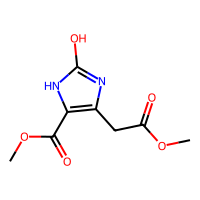
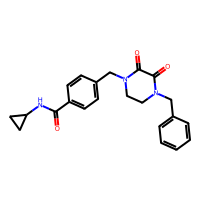
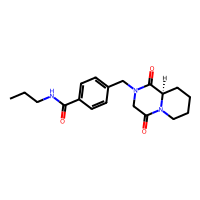
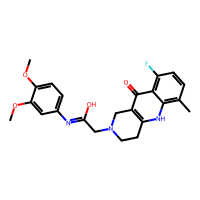
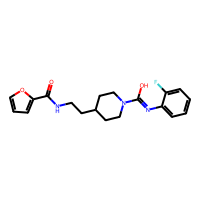
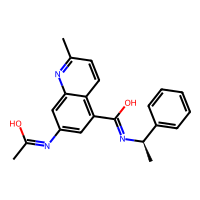
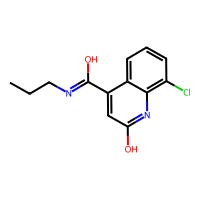
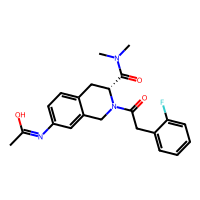
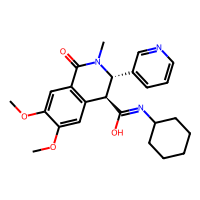
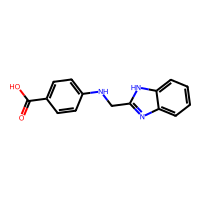
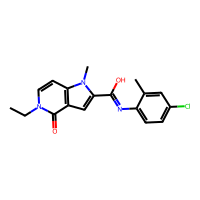
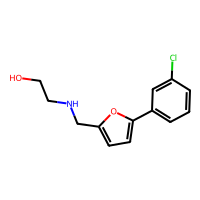
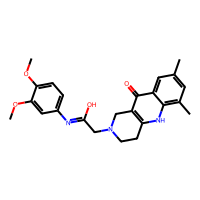
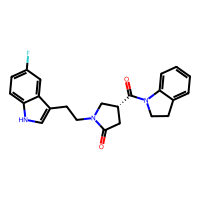
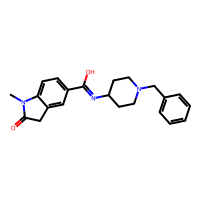
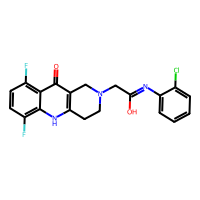
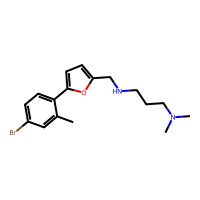
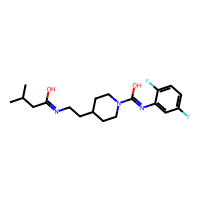
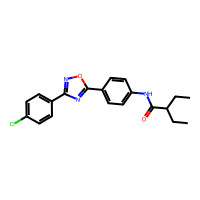
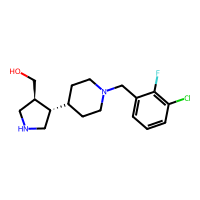

In [55]:
dr_examples = examples_df[[False if (x.lower().count("n")>3 or "s" in x.lower()) else True for x in examples_df["SMILES"]]].sort_values("d_median_R",ascending=False)[:20]
PandasTools.ChangeMoleculeRendering(dr_examples)
dr_examples

,SMILES,EXP,p_median,p_std,d_median,d_median_R,Mol
52010,COC(=O)Cc1nc(O)[nH]c1C(=O)OC,1102.3,565.414900,20.232578,536.885100,0.949542,
18306,CCOC(=O)c1c(C)n(Cc2ccco2)c2ccc(OCC)cc12,617.2,1115.603800,22.363421,498.403800,0.446757,
17306,CCCN=C(O)c1cc(O)nc2c(Cl)cccc12,1082.8,670.006840,10.062435,412.793160,0.616103,
64358,CCCn1ccc2oc(C)c(C(O)=NCc3ccc(C(C)C)cc3)c2c1=O,786.3,1182.577517,13.814049,396.277517,0.335096,
63636,CCCC(=O)N1CCc2c([nH]c3ccccc23)[C@H]1c1ccc(F)cc1,698.4,1084.643100,12.585158,386.243100,0.356102,
49322,CCOC(=O)COC(=O)c1cn(-c2ccc(CC)cc2)c(=O)c2ccccc12,737.0,1112.866000,26.941260,375.866000,0.337746,
23352,COc1cccc(N=C(O)N2C[C@H](C)Oc3ccc(C)cc32)c1,654.4,1024.181400,5.915003,369.781400,0.361051,
1323,CCCCCCCCOC(=O)/C=C/c1ccc(O)c(O)c1,630.2,998.224850,24.891893,368.024850,0.368679,
11962,Cc1oc2ccn(Cc3ccccc3F)c(=O)c2c1C(O)=NCc1cccc(F)c1,725.7,1084.045900,10.352928,358.345900,0.330563,
15442,OCCNCc1ccc(-c2cccc(Cl)c2)o1,986.8,630.127500,21.473194,356.672500,0.566032,

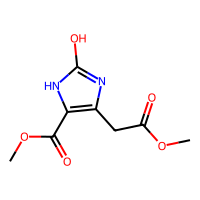
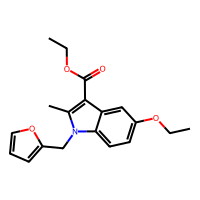
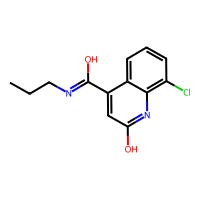
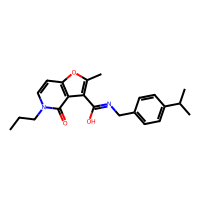
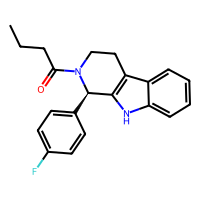
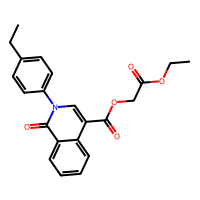
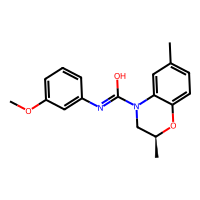
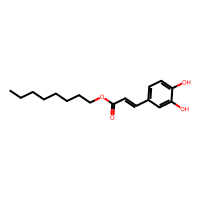
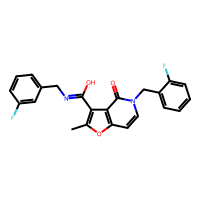
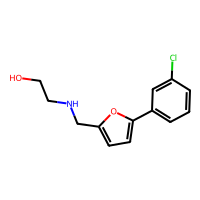
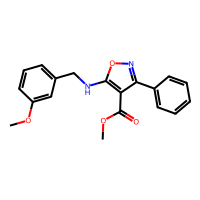
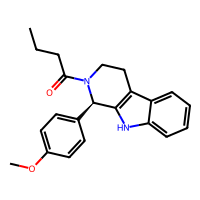
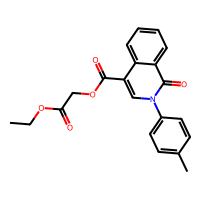
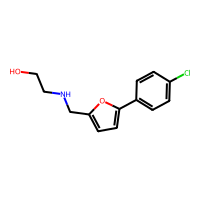
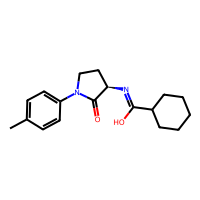
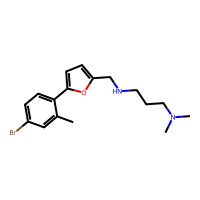
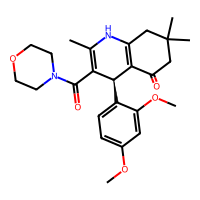
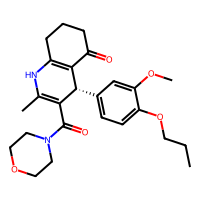
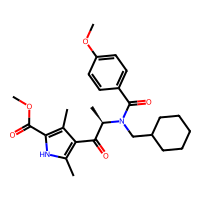
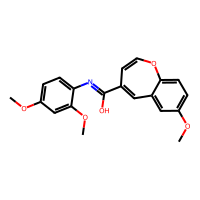

In [56]:
d_examples = examples_df[[False if (x.lower().count("n")>2 or "s" in x.lower()) else True for x in examples_df["SMILES"]]].sort_values("d_median",ascending=False)[:20]
PandasTools.ChangeMoleculeRendering(d_examples)
d_examples

,SMILES,EXP,p_median,p_std,d_median,d_median_R,Mol
18306,CCOC(=O)c1c(C)n(Cc2ccco2)c2ccc(OCC)cc12,617.2,1115.603800,22.363421,498.403800,0.446757,
64358,CCCn1ccc2oc(C)c(C(O)=NCc3ccc(C(C)C)cc3)c2c1=O,786.3,1182.577517,13.814049,396.277517,0.335096,
63636,CCCC(=O)N1CCc2c([nH]c3ccccc23)[C@H]1c1ccc(F)cc1,698.4,1084.643100,12.585158,386.243100,0.356102,
49322,CCOC(=O)COC(=O)c1cn(-c2ccc(CC)cc2)c(=O)c2ccccc12,737.0,1112.866000,26.941260,375.866000,0.337746,
23352,COc1cccc(N=C(O)N2C[C@H](C)Oc3ccc(C)cc32)c1,654.4,1024.181400,5.915003,369.781400,0.361051,
1323,CCCCCCCCOC(=O)/C=C/c1ccc(O)c(O)c1,630.2,998.224850,24.891893,368.024850,0.368679,
11962,Cc1oc2ccn(Cc3ccccc3F)c(=O)c2c1C(O)=NCc1cccc(F)c1,725.7,1084.045900,10.352928,358.345900,0.330563,
67763,COC(=O)c1c(-c2ccccc2)noc1NCc1cccc(OC)c1,677.1,1030.483145,20.560763,353.383145,0.342930,
1266,CCCC(=O)N1CCc2c([nH]c3ccccc23)[C@H]1c1ccc(OC)cc1,720.5,1054.705528,12.182420,334.205528,0.316871,
64996,CCOC(=O)COC(=O)c1cn(-c2ccc(C)cc2)c(=O)c2ccccc12,717.9,1045.026815,7.935717,327.126815,0.313032,

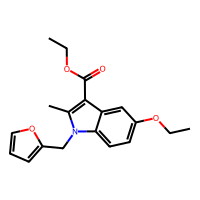
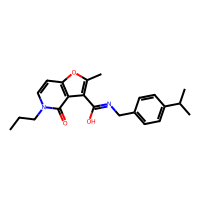
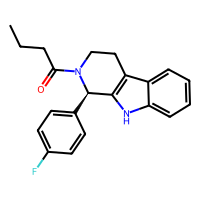
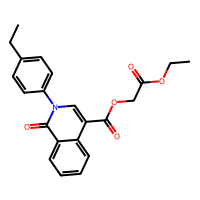
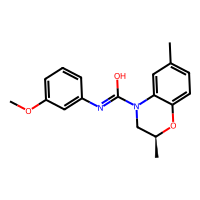
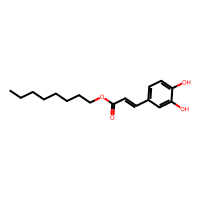
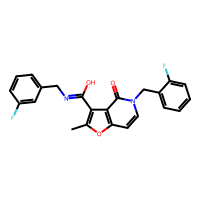
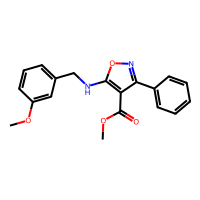
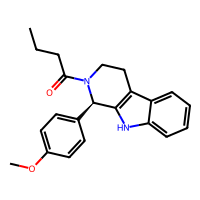
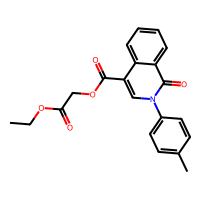
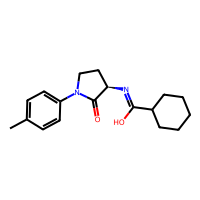
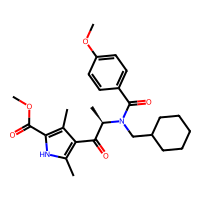
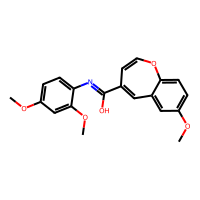
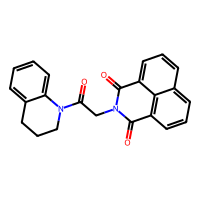
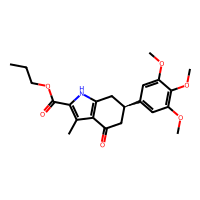
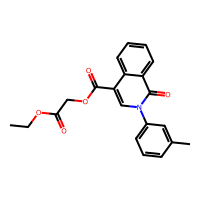
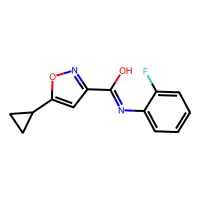
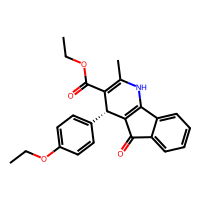
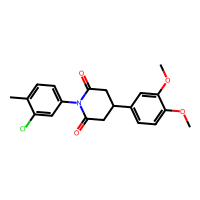
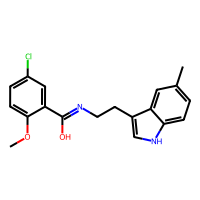

In [57]:
a_examples = examples_df[[False if (x.lower().count("n")>2 or "s" in x.lower()) else True for x in examples_df["SMILES"]]].sort_values("d_median",ascending=False)
a_examples = a_examples[a_examples["p_median"]>a_examples["EXP"]][:20]
PandasTools.ChangeMoleculeRendering(a_examples)
a_examples

,SMILES,EXP,p_median,p_std,d_median,d_median_R,Mol
52010,COC(=O)Cc1nc(O)[nH]c1C(=O)OC,1102.3,565.414900,20.232578,536.885100,0.949542,
17306,CCCN=C(O)c1cc(O)nc2c(Cl)cccc12,1082.8,670.006840,10.062435,412.793160,0.616103,
15442,OCCNCc1ccc(-c2cccc(Cl)c2)o1,986.8,630.127500,21.473194,356.672500,0.566032,
46605,OCCNCc1ccc(-c2ccc(Cl)cc2)o1,965.5,643.552500,16.182645,321.947500,0.500266,
39993,Cc1cc(Br)ccc1-c1ccc(CNCCCN(C)C)o1,927.3,609.677730,26.625173,317.622270,0.520967,
7420,COc1ccc([C@H]2C(C(=O)N3CCOCC3)=C(C)NC3=C2C(=O)...,973.3,655.775449,19.817789,317.524551,0.484197,
48438,CCCOc1ccc([C@@H]2C(C(=O)N3CCOCC3)=C(C)NC3=C2C(...,964.3,647.098025,18.909764,317.201975,0.490192,
33416,CCN1C(=O)c2ccccc2Oc2ccc(C(O)=NCc3ccc4c(c3)OCO4...,1168.3,870.869750,7.720744,297.430250,0.341532,
36475,COC(=O)c1[nH]c(C)c(C(=O)CN(C[C@@H]2CCCO2)C(=O)...,1027.6,731.561000,23.542269,296.039000,0.404668,
77753,OC[C@@H]1CNC[C@H]1C1CCN(Cc2cccc(Cl)c2F)CC1,806.1,535.157040,8.132231,270.942960,0.506287,

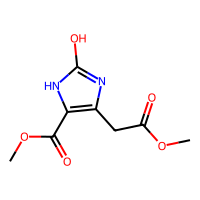
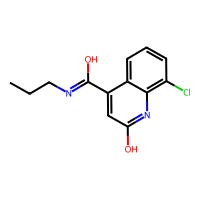
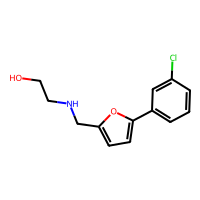
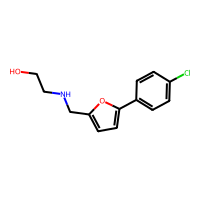
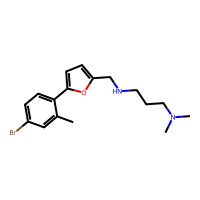
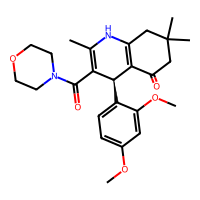
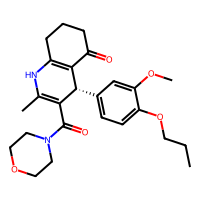
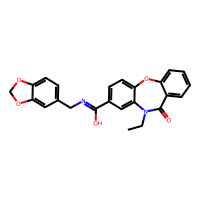
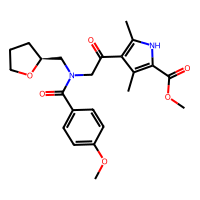
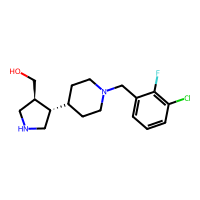
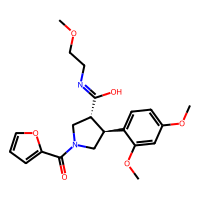
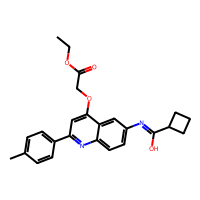
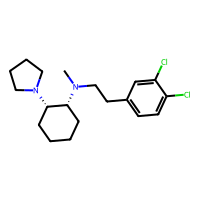
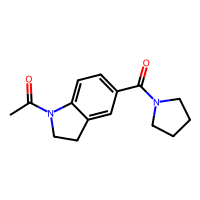
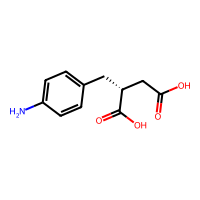
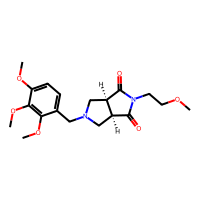

In [58]:
b_examples = examples_df[[False if (x.lower().count("n")>2 or "s" in x.lower()) else True for x in examples_df["SMILES"]]].sort_values("d_median",ascending=False)
b_examples = b_examples[b_examples["p_median"]<b_examples["EXP"]][:20]
PandasTools.ChangeMoleculeRendering(b_examples)
b_examples

In [59]:
def mol_draw(mol):
    d2d = Draw.MolDraw2DCairo(6000,3000)
    dos = d2d.drawOptions()
    dos.scaleBondWidth = True
    dos.bondLineWidth=5
    dos.baseFontSize=1
    dos.maxFontSize = 2000
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return Image.open(BytesIO(d2d.GetDrawingText()))


,SMILES,EXP,p_median,p_std,d_median,d_median_R,Mol
1323,CCCCCCCCOC(=O)/C=C/c1ccc(O)c(O)c1,630.2,998.22485,24.891893,368.02485,0.368679,
17306,CCCN=C(O)c1cc(O)nc2c(Cl)cccc12,1082.8,670.00684,10.062435,412.79316,0.616103,
20415,CN(CCc1ccc(Cl)c(Cl)c1)[C@@H]1CCCC[C@@H]1N1CCCC1,955.7,719.55380,22.150156,236.14620,0.328184,
52010,COC(=O)Cc1nc(O)[nH]c1C(=O)OC,1102.3,565.41490,20.232578,536.88510,0.949542,

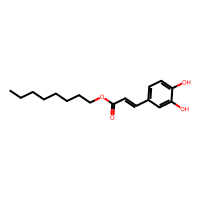
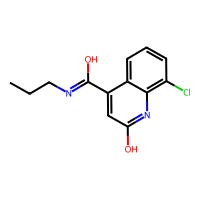
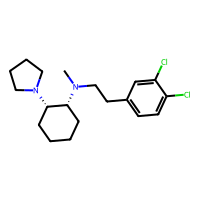
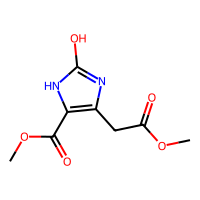

In [60]:
sel_examples_df = examples_df.loc[sorted([52010,1323,17306, 20415]),:]
PandasTools.ChangeMoleculeRendering(sel_examples_df)
sel_examples_df

In [61]:
for i,row in sel_examples_df.iterrows():
    img = mol_draw(row["Mol"])
    img.save(OUTPUT_FOLDER/f"{row["SMILES"].replace('\\','').replace('/','')}.png")

,SMILES,EXP,p_median,p_std,d_median,d_median_R,Mol
11962,Cc1oc2ccn(Cc3ccccc3F)c(=O)c2c1C(O)=NCc1cccc(F)c1,725.7,1084.045900,10.352928,358.345900,0.330563,
15442,OCCNCc1ccc(-c2cccc(Cl)c2)o1,986.8,630.127500,21.473194,356.672500,0.566032,
38678,COc1ccc2c(c1)C=C(C(O)=Nc1ccc(OC)cc1OC)C=CO2,698.8,1006.497645,17.606425,307.697645,0.305711,
46605,OCCNCc1ccc(-c2ccc(Cl)cc2)o1,965.5,643.552500,16.182645,321.947500,0.500266,
62468,CC(=O)N1CCc2cc(C(=O)N3CCCC3)ccc21,869.1,636.188718,14.541094,232.911282,0.366104,
67763,COC(=O)c1c(-c2ccccc2)noc1NCc1cccc(OC)c1,677.1,1030.483145,20.560763,353.383145,0.342930,

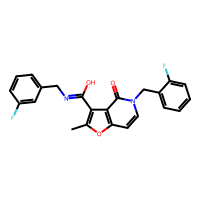
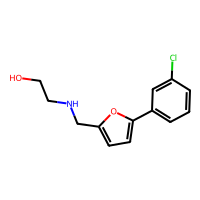
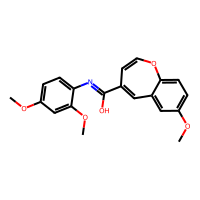
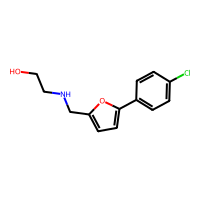
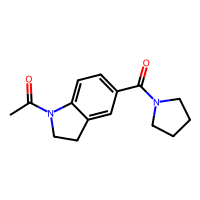
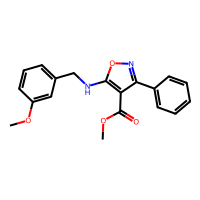

In [62]:
sel1_examples_df = examples_df.loc[sorted([15442,46605,62468,11962,67763,38678]),:]
PandasTools.ChangeMoleculeRendering(sel1_examples_df)
sel1_examples_df

In [63]:
for i,row in sel1_examples_df.iterrows():
    img = mol_draw(row["Mol"])
    img.save(OUTPUT_FOLDER/f"{row["SMILES"]}.png")